# imports

In [17]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import numpy as np
import pandas as pd
from scipy.spatial import distance
from statistics import median, mean
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# definitions

In [18]:
hdf5_path_front = '/home/box/coding/CTIR/videos/experiment_1/E1_frontDLC_resnet101_Moused_2Jul5shuffle1_10000.h5'
hdf5_path_side = '/home/box/coding/CTIR/videos/experiment_1/E1_sideDLC_resnet101_Moused_2Jul5shuffle1_10000.h5'
hdf5_path_top = '/home/box/coding/CTIR/videos/experiment_1/E1_topDLC_resnet101_Moused_2Jul5shuffle1_10000.h5'
lock_box_parts = {
    "middle_front": (0, 0, 0),
    "lever_tip": (49, 24, 15),
    "upper_lever_tip": (49, 87, 82),
    "stick_head": (-9, 35, 9),
    "ball": (86, 34, 15),
    "sliding_door": (86, 67, 10),
    "middle_back": (0, 140, 0),
    "left_front": (120, 0, 0)
}
data = {
    'file': ['E1_front.png', 'E1_side.png', 'E1_top.png'],
    'lever_tip_x': [525.36, 808.65, 352.30],
    'lever_tip_y': [446.67, 373.74, 162.13],
    'upper_lever_tip_x': [506.80, 513.50, 348.21],
    'upper_lever_tip_y': [109.76, 66.99, 302.43],
    'stick_head_x': [261.87, 734.33, 501.62],
    'stick_head_y': [474.28, 463.10, 201.38],
    'ball_x': [688.95, 759.18, 253.07],
    'ball_y': [439.52, 350.62, 194.87],
    'sliding_door_x': [675.83, 638.41, 254.25],
    'sliding_door_y': [402.94, 350.62, 274.80],
    'middle_front_x': [308.33, 891.28, 471.89],
    'middle_front_y': [547.63, 486.68, 122.95],
    'middle_back_x': [317.01, 256.59, 471.34],
    'middle_back_y': [402.21, 482.78, 469.96],
    'left_front_x': [844.89, 891.41, 182.05],
    'left_front_y': [522.60, 380.02, 118.33]
}


# functions

In [19]:
def triangulate_points(points_2d_front, points_2d_side, points_2d_top, P_front, P_side, P_top):
    points_3d = []
    for i in range(points_2d_front.shape[0]):
        A = []
        x, y = points_2d_front[i]
        A.append(x * P_front[2, :] - P_front[0, :])
        A.append(y * P_front[2, :] - P_front[1, :])
        
        x, y = points_2d_side[i]
        A.append(x * P_side[2, :] - P_side[0, :])
        A.append(y * P_side[2, :] - P_side[1, :])
        
        x, y = points_2d_top[i]
        A.append(x * P_top[2, :] - P_top[0, :])
        A.append(y * P_top[2, :] - P_top[1, :])
        
        A = np.array(A)
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]
        points_3d.append(X[:3] / X[3])
    return np.array(points_3d)
def weighted_triangulate_points(points_2d_front, points_2d_side, points_2d_top, P_front, P_side, P_top, likelihoods):
    points_3d = []
    for i in range(points_2d_front.shape[0]):
        A = []
        
        x, y = points_2d_front[i]
        A.append(likelihoods['front'][i] * (x * P_front[2, :] - P_front[0, :]))
        A.append(likelihoods['front'][i] * (y * P_front[2, :] - P_front[1, :]))
        
        x, y = points_2d_side[i]
        A.append(likelihoods['side'][i] * (x * P_side[2, :] - P_side[0, :]))
        A.append(likelihoods['side'][i] * (y * P_side[2, :] - P_side[1, :]))
        
        x, y = points_2d_top[i]
        A.append(likelihoods['top'][i] * (x * P_top[2, :] - P_top[0, :]))
        A.append(likelihoods['top'][i] * (y * P_top[2, :] - P_top[1, :]))
        
        A = np.array(A)
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]
        points_3d.append(X[:3] / X[3])
    
    return np.array(points_3d)
def distance_3d(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2 + (coord1[2] - coord2[2])**2)
def calculate_distance(df):
    d = []
    for i in range(len(df) - 1):
        dist = distance_3d(
            [df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['z']],
            [df.iloc[i+1]['x'], df.iloc[i+1]['y'], df.iloc[i+1]['z']]
        )
        d.append(dist)
    d.append(0)
    df['dist'] = d
def triangle_area_3d(A, B, C):
    # Convert points to numpy arrays
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)
    
    # Compute the vectors AB and AC
    AB = B - A
    AC = C - A
    
    # Compute the cross product of AB and AC
    cross_product = np.cross(AB, AC)
    
    # Compute the magnitude of the cross product
    area = np.linalg.norm(cross_product) / 2.0
    
    return area
def triangle_centroid_3d(A, B, C):
    # Convert points to numpy arrays
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)
    
    # Compute the centroid
    centroid = (A + B + C) / 3.0
    
    return centroid
def calculate_camera_params(points_3d, points_2d):
    num_points = points_3d.shape[0]
    A = []
    for i in range(num_points):
        X, Y, Z = points_3d[i]
        u, v = points_2d[i]
        A.append([-X, -Y, -Z, -1, 0, 0, 0, 0, u*X, u*Y, u*Z, u])
        A.append([0, 0, 0, 0, -X, -Y, -Z, -1, v*X, v*Y, v*Z, v])
    A = np.array(A)
    
    # Perform SVD
    U, S, Vt = np.linalg.svd(A)
    P = Vt[-1].reshape(3, 4)
    
    # Decompose P to obtain K, R, t
    K, R, t = cv2.decomposeProjectionMatrix(P)[:3]
    K /= K[2, 2]  # Normalize K to make K[2, 2] = 1
    
    # Correct the sign and orientation if needed
    if np.linalg.det(R) < 0:
        R = -R
        t = -t
    
    return K, R, t, P
def calculate_reprojection_error(P, points_3d, points_2d):
    num_points = points_3d.shape[0]
    points_2d_reproj = P @ np.hstack((points_3d, np.ones((num_points, 1)))).T
    points_2d_reproj /= points_2d_reproj[2]  # Divide by the last row to normalize
    points_2d_reproj = points_2d_reproj[:2].T
    reprojection_error = np.mean(np.linalg.norm(points_2d - points_2d_reproj, axis=1))
    return reprojection_error
def extract_xyz(df, index):
    if index not in df.index:
        raise ValueError("Index not found in DataFrame.")
    return df.loc[index, ['x', 'y', 'z']].values




# projection matrix

In [20]:
# Convert dictionary to numpy array
points_3d = np.array(list(lock_box_parts.values()), dtype='float32')

df = pd.DataFrame(data)

# Extract 2D points for the front view (E1_front.png)
points_2d_front = df[['middle_front_x', 'lever_tip_x', 'upper_lever_tip_x', 'stick_head_x', 'ball_x', 'sliding_door_x', 'middle_back_x', 'left_front_x']].iloc[0].values
points_2d_front = np.vstack((points_2d_front, df[['middle_front_y', 'lever_tip_y', 'upper_lever_tip_y', 'stick_head_y', 'ball_y', 'sliding_door_y', 'middle_back_y', 'left_front_y']].iloc[0].values)).T

points_2d_side = df[['middle_front_x', 'lever_tip_x', 'upper_lever_tip_x', 'stick_head_x', 'ball_x', 'sliding_door_x', 'middle_back_x', 'left_front_x']].iloc[1].values
points_2d_side = np.vstack((points_2d_side, df[['middle_front_y', 'lever_tip_y', 'upper_lever_tip_y', 'stick_head_y', 'ball_y', 'sliding_door_y', 'middle_back_y', 'left_front_y']].iloc[1].values)).T

points_2d_top = df[['middle_front_x', 'lever_tip_x', 'upper_lever_tip_x', 'stick_head_x', 'ball_x', 'sliding_door_x', 'middle_back_x', 'left_front_x']].iloc[2].values
points_2d_top = np.vstack((points_2d_top, df[['middle_front_y', 'lever_tip_y', 'upper_lever_tip_y', 'stick_head_y', 'ball_y', 'sliding_door_y', 'middle_back_y', 'left_front_y']].iloc[2].values)).T


# Calculate camera parameters and reprojection errors for each view
K_front, R_front, t_front, P_front = calculate_camera_params(points_3d, points_2d_front)
reprojection_error_front = calculate_reprojection_error(P_front, points_3d, points_2d_front)

K_side, R_side, t_side, P_side = calculate_camera_params(points_3d, points_2d_side)
reprojection_error_side = calculate_reprojection_error(P_side, points_3d, points_2d_side)

K_top, R_top, t_top, P_top = calculate_camera_params(points_3d, points_2d_top)
reprojection_error_top = calculate_reprojection_error(P_top, points_3d, points_2d_top)

# lockbox elements

In [21]:
# Load the data
box_f = pd.read_hdf(hdf5_path_front)
box_s = pd.read_hdf(hdf5_path_side)
box_t = pd.read_hdf(hdf5_path_top)

columns_to_keep = ['lever_tip', 'upper_lever_tip', 'stick_head', 'ball', 'sliding_door']

box_f = box_f.loc[:, box_f.columns.get_level_values(1).isin(columns_to_keep)]
box_s = box_s.loc[:, box_s.columns.get_level_values(1).isin(columns_to_keep)]
box_t = box_t.loc[:, box_t.columns.get_level_values(1).isin(columns_to_keep)]

box_f.columns = box_f.columns.droplevel(0)
box_s.columns = box_s.columns.droplevel(0)
box_t.columns = box_t.columns.droplevel(0)

box_f.columns = box_f.columns.map('_'.join).str.strip('|')
box_s.columns = box_s.columns.map('_'.join).str.strip('|')
box_t.columns = box_t.columns.map('_'.join).str.strip('|')
# Stack the data
lever_tip_f = np.column_stack((box_f['lever_tip_x'], box_f['lever_tip_y']))
lever_tip_s = np.column_stack((box_s['lever_tip_x'], box_s['lever_tip_y']))
lever_tip_t = np.column_stack((box_t['lever_tip_x'], box_t['lever_tip_y']))

upper_lever_tip_f = np.column_stack((box_f['upper_lever_tip_x'], box_f['upper_lever_tip_y']))
upper_lever_tip_s = np.column_stack((box_s['upper_lever_tip_x'], box_s['upper_lever_tip_y']))
upper_lever_tip_t = np.column_stack((box_t['upper_lever_tip_x'], box_t['upper_lever_tip_y']))

stick_head_f = np.column_stack((box_f['stick_head_x'], box_f['stick_head_y']))
stick_head_s = np.column_stack((box_s['stick_head_x'], box_s['stick_head_y']))
stick_head_t = np.column_stack((box_t['stick_head_x'], box_t['stick_head_y']))

ball_f = np.column_stack((box_f['ball_x'], box_f['ball_y']))
ball_s = np.column_stack((box_s['ball_x'], box_s['ball_y']))
ball_t = np.column_stack((box_t['ball_x'], box_t['ball_y']))

sliding_door_f = np.column_stack((box_f['sliding_door_x'], box_f['sliding_door_y']))
sliding_door_s = np.column_stack((box_s['sliding_door_x'], box_s['sliding_door_y']))
sliding_door_t = np.column_stack((box_t['sliding_door_x'], box_t['sliding_door_y']))

# Likelihoods
lever_tip_lks = pd.DataFrame({'front': box_f['lever_tip_likelihood'], 'side': box_s['lever_tip_likelihood'], 'top': box_t['lever_tip_likelihood']})
upper_lever_tip_lks = pd.DataFrame({'front': box_f['upper_lever_tip_likelihood'], 'side': box_s['upper_lever_tip_likelihood'], 'top': box_t['upper_lever_tip_likelihood']})
stick_head_lks = pd.DataFrame({'front': box_f['stick_head_likelihood'], 'side': box_s['stick_head_likelihood'], 'top': box_t['stick_head_likelihood']})
ball_lks = pd.DataFrame({'front': box_f['ball_likelihood'], 'side': box_s['ball_likelihood'], 'top': box_t['ball_likelihood']})
sliding_door_lks = pd.DataFrame({'front': box_f['sliding_door_likelihood'], 'side': box_s['sliding_door_likelihood'], 'top': box_t['sliding_door_likelihood']})

# Triangulate points
lever_tip_3d = triangulate_points(lever_tip_f, lever_tip_s, lever_tip_t, P_front, P_side, P_top)
upper_lever_tip_3d = triangulate_points(upper_lever_tip_f, upper_lever_tip_s, upper_lever_tip_t, P_front, P_side, P_top)
stick_head_3d = triangulate_points(stick_head_f, stick_head_s, stick_head_t, P_front, P_side, P_top)
ball_3d = triangulate_points(ball_f, ball_s, ball_t, P_front, P_side, P_top)
sliding_door_3d = triangulate_points(sliding_door_f, sliding_door_s, sliding_door_t, P_front, P_side, P_top)
#turn into df
lever_tip_3d = pd.DataFrame(lever_tip_3d, columns=['x', 'y', 'z'])
upper_lever_tip_3d = pd.DataFrame(upper_lever_tip_3d, columns=['x', 'y', 'z'])
stick_head_3d = pd.DataFrame(stick_head_3d, columns=['x', 'y', 'z'])
ball_3d = pd.DataFrame(ball_3d, columns=['x', 'y', 'z'])
sliding_door_3d = pd.DataFrame(sliding_door_3d, columns=['x', 'y', 'z'])

calculate_distance(lever_tip_3d)
calculate_distance(upper_lever_tip_3d)
calculate_distance(stick_head_3d)
calculate_distance(ball_3d)
calculate_distance(sliding_door_3d)

# body parts likelihood matrix

In [22]:
# Load the data
data_f = pd.read_hdf(hdf5_path_front)
data_s = pd.read_hdf(hdf5_path_side)
data_t = pd.read_hdf(hdf5_path_top)

columns_to_keep = ['nose', 'ear_left', 'ear_right','body_center','tail_base']

data_f = data_f.loc[:, data_f.columns.get_level_values(1).isin(columns_to_keep)]
data_s = data_s.loc[:, data_s.columns.get_level_values(1).isin(columns_to_keep)]
data_t = data_t.loc[:, data_t.columns.get_level_values(1).isin(columns_to_keep)]

data_f.columns = data_f.columns.droplevel(0)
data_s.columns = data_s.columns.droplevel(0)
data_t.columns = data_t.columns.droplevel(0)

data_f.columns = data_f.columns.map('_'.join).str.strip('|')
data_s.columns = data_s.columns.map('_'.join).str.strip('|')
data_t.columns = data_t.columns.map('_'.join).str.strip('|')

# Convert data to 2D arrays
nose_f = np.column_stack((data_f['nose_x'], data_f['nose_y']))
nose_s = np.column_stack((data_s['nose_x'], data_s['nose_y']))
nose_t = np.column_stack((data_t['nose_x'], data_t['nose_y']))

ear_l_f = np.column_stack((data_f['ear_left_x'], data_f['ear_left_y']))
ear_l_s = np.column_stack((data_s['ear_left_x'], data_s['ear_left_y']))
ear_l_t = np.column_stack((data_t['ear_left_x'], data_t['ear_left_y']))

ear_r_f = np.column_stack((data_f['ear_right_x'], data_f['ear_right_y']))
ear_r_s = np.column_stack((data_s['ear_right_x'], data_s['ear_right_y']))
ear_r_t = np.column_stack((data_t['ear_right_x'], data_t['ear_right_y']))

nose_lks = pd.DataFrame({'front':data_f['nose_likelihood'],'side':data_s['nose_likelihood'], 'top':data_t['nose_likelihood']})
ear_l_lks = pd.DataFrame({'front':data_f['ear_left_likelihood'],'side':data_s['ear_left_likelihood'], 'top':data_t['ear_left_likelihood']})
ear_r_lks = pd.DataFrame({'front':data_f['ear_right_likelihood'],'side':data_s['ear_right_likelihood'], 'top':data_t['ear_right_likelihood']})

# Triangulate points
nose_3d = weighted_triangulate_points(nose_f, nose_s, nose_t, P_front, P_side, P_top, nose_lks)
ear_l_3d = weighted_triangulate_points(ear_l_f, ear_l_s, ear_l_t, P_front, P_side, P_top, ear_l_lks)
ear_r_3d = weighted_triangulate_points(ear_r_f, ear_r_s, ear_r_t, P_front, P_side, P_top, ear_r_lks)

mouse_triangle = []
t_x = []
t_y = []
t_z = []
nose_likelihood = []
ear_left_likelihood = []
ear_right_likelihood = []

# Loop to calculate values and append to lists
for i in range(len(nose_3d)):
    x,y,z = triangle_centroid_3d(nose_3d[i], ear_l_3d[i], ear_r_3d[i])
    mouse_triangle.append(triangle_area_3d(nose_3d[i], ear_l_3d[i], ear_r_3d[i]))
    t_x.append(x)
    t_y.append(y)
    t_z.append(z)
    nose_likelihood.append(data_f['nose_likelihood'][i] + data_s['nose_likelihood'][i] + data_t['nose_likelihood'][i])
    ear_left_likelihood.append(data_f['ear_left_likelihood'][i] + data_s['ear_left_likelihood'][i] + data_t['ear_left_likelihood'][i])
    ear_right_likelihood.append(data_f['ear_right_likelihood'][i] + data_s['ear_right_likelihood'][i] + data_t['ear_right_likelihood'][i])


likelihood_show = pd.DataFrame({
    'mouse_triangle': mouse_triangle,
    'x':t_x,
    'y':t_y,
    'z':t_z,
    'nose_likelihood': nose_likelihood,
    'ear_left_likelihood': ear_left_likelihood,
    'ear_right_likelihood': ear_right_likelihood
})

likelihood_show['total_likelihood'] = likelihood_show[['nose_likelihood', 'ear_left_likelihood', 'ear_right_likelihood']].sum(axis=1)
likelihood_show['hits'] = likelihood_show[['nose_likelihood', 'ear_left_likelihood', 'ear_right_likelihood']].gt(1.5).sum(axis=1)

likelihood_show['f_n'] = data_f['nose_likelihood']
likelihood_show['s_n'] = data_s['nose_likelihood']
likelihood_show['t_n'] = data_t['nose_likelihood']

likelihood_show['f_e_l'] = data_f['ear_left_likelihood']
likelihood_show['s_e_l'] = data_s['ear_left_likelihood']
likelihood_show['t_e_l'] = data_t['ear_left_likelihood']

likelihood_show['f_e_r'] = data_f['ear_right_likelihood']
likelihood_show['s_e_r'] = data_s['ear_right_likelihood']
likelihood_show['t_e_r'] = data_t['ear_right_likelihood']

likelihood_show['h_n'] = likelihood_show[['f_n', 's_n', 't_n']].gt(0.7).sum(axis=1)
likelihood_show['h_e_l'] = likelihood_show[['f_e_l', 's_e_l', 't_e_l']].gt(0.7).sum(axis=1)
likelihood_show['h_e_r'] = likelihood_show[['f_e_r', 's_e_r', 't_e_r']].gt(0.7).sum(axis=1)
likelihood_show['h_sub'] = likelihood_show[['h_n', 'h_e_l', 'h_e_r']].sum(axis=1)
likelihood_show['low'] = likelihood_show[['h_n', 'h_e_l', 'h_e_r']].min(axis=1)

d = []
for i in range(len(likelihood_show) - 1):
    if(likelihood_show.iloc[i]['low'] < 2 or likelihood_show.iloc[i+1]['low'] < 2):
        d.append(0)
    else:
        dist = distance_3d(
            [likelihood_show.iloc[i]['x'], likelihood_show.iloc[i]['y'], likelihood_show.iloc[i]['z']], 
            [likelihood_show.iloc[i+1]['x'], likelihood_show.iloc[i+1]['y'], likelihood_show.iloc[i+1]['z']]
        )
        d.append(dist)              
d.append(0)
likelihood_show['dist'] = d


# annotations, movement of lock box elements

In [23]:
data = np.load('/home/box/coding/CTIR/2021-03-05_08-22-05_manual_annotations.npz')
ethogram_interactions = data['ethogram_interactions']
annotator_data_1 = ethogram_interactions[0]
annotator_data_2 = ethogram_interactions[1]

annotator_lever_df = pd.DataFrame({'l1':annotator_data_1[0, :len(lever_tip_3d)], 'l2':annotator_data_2[0, :len(lever_tip_3d)]})
annotator_stick_df = pd.DataFrame({'l1':annotator_data_1[1, :len(lever_tip_3d)], 'l2':annotator_data_2[1, :len(lever_tip_3d)]})
annotator_ball_df = pd.DataFrame({'l1':annotator_data_1[2, :len(lever_tip_3d)], 'l2':annotator_data_2[2, :len(lever_tip_3d)]})
annotator_door_df = pd.DataFrame({'l1':annotator_data_1[3, :len(lever_tip_3d)], 'l2':annotator_data_2[3, :len(lever_tip_3d)]})

annotator_lever_df['sum'] = (annotator_lever_df['l1'].astype(bool) | annotator_lever_df['l2'].astype(bool)).astype(int)
annotator_stick_df['sum'] = (annotator_stick_df['l1'].astype(bool) | annotator_stick_df['l2'].astype(bool)).astype(int)
annotator_ball_df['sum'] = (annotator_ball_df['l1'].astype(bool) | annotator_ball_df['l2'].astype(bool)).astype(int)
annotator_door_df['sum'] = (annotator_door_df['l1'].astype(bool) | annotator_door_df['l2'].astype(bool)).astype(int)

annotator_lever_df['d_lever'] = (lever_tip_3d['dist'].apply(lambda x: 1 if x > 5 else 0)).astype(int)
annotator_stick_df['d_stick'] = (stick_head_3d['dist'].apply(lambda x: 1 if x > 5 else 0)).astype(int)
annotator_ball_df['d_ball'] = (ball_3d['dist'].apply(lambda x: 1 if x > 5 else 0)).astype(int)
annotator_door_df['d_door'] = (sliding_door_3d['dist'].apply(lambda x: 1 if x > 5 else 0)).astype(int)

## mouse model and bounding boxes

In [71]:
mouse_model_df = likelihood_show[['x','y','z']]
#parameters
mouse_radius = 23
lever_width = 10

len_stick = distance_3d(extract_xyz(ball_3d,900),extract_xyz(stick_head_3d,900))
cylinder_radius = 5

door_width = 40
door_length = 40
door_height = 5

ball_radius = 3

### lever

In [25]:
def create_bounding_box_vertices(end1, end2, corner, width):
    vertices = np.array([
        end1,
        corner,
        end2,
        end1 + np.array([0, width, 0]),
        corner + np.array([0, width, 0]),
        end2 + np.array([0, width, 0]),
        end1 + np.array([0, 0, width]),
        corner + np.array([0, 0, width]),
        end2 + np.array([0, 0, width]),
        end1 + np.array([0, width, width]),
        corner + np.array([0, width, width]),
        end2 + np.array([0, width, width])
    ])
    return vertices
def is_within_radius_of_bounding_box(point, vertices, radius=1.0):
    for vertex in vertices:
        dist = distance.euclidean(point, vertex)
        if dist <= radius:
            return 1
    return 0

# find hinge coordinates
def find_corner_point(P1, P2):
    P1 = np.array(P1)
    P2 = np.array(P2)
    
    M = (P1 + P2) / 2
    vector_P1_P2 = P2 - P1
    perpendicular_vector = np.cross(vector_P1_P2, [0, 0, 1])
    perpendicular_vector = perpendicular_vector / np.linalg.norm(perpendicular_vector)
    
    length = np.linalg.norm(vector_P1_P2) / 2
    C = M + perpendicular_vector * length
    
    return C
def average_corner_point(df1, df2):
    corner_points = []

    common_indices = df1.index.intersection(df2.index)
    
    for idx in common_indices:
        P1 = df1.loc[idx].values
        P2 = df2.loc[idx].values
        corner_point = find_corner_point(P1, P2)
        corner_points.append(corner_point)
    
    average_corner = np.mean(corner_points, axis=0)
    return average_corner

data1 = lever_tip_3d[['x','y','z']][lever_tip_3d['dist'] < 3]
data2 = upper_lever_tip_3d[['x','y','z']][upper_lever_tip_3d['dist'] < 3]

# Calculating average corner point
average_corner = average_corner_point(data1, data2)

# Define faces of the L shape
faces = [
    [0, 1, 4, 3],  # Front face from end1 to corner
    [1, 2, 5, 4],  # Front face from corner to end2
    [0, 3, 9, 6],  # Side face from end1, bottom
    [1, 4, 10, 7], # Side face from corner, bottom
    [2, 5, 11, 8], # Side face from end2, bottom
    [3, 4, 10, 9], # Top face corner region
    [4, 5, 11, 10], # Top face end2 region
    [6, 7, 10, 9], # Bottom face corner region
    [7, 8, 11, 10], # Bottom face end2 region
    [0, 6, 7, 1],  # Vertical side face end1 to corner
    [1, 7, 8, 2],  # Vertical side face corner to end2
]

results = []

for ind in range(len(mouse_model_df)):
    mouse_point = np.array([mouse_model_df.loc[ind, 'x'], mouse_model_df.loc[ind, 'y'], mouse_model_df.loc[ind, 'z']])
    end1 = np.array([lever_tip_3d.loc[ind, 'x'], lever_tip_3d.loc[ind, 'y'], lever_tip_3d.loc[ind, 'z']])
    end2 = np.array([upper_lever_tip_3d.loc[ind, 'x'], upper_lever_tip_3d.loc[ind, 'y'], upper_lever_tip_3d.loc[ind, 'z']])
    corner = np.array(average_corner)  # Assuming corner is constant, modify if needed
    
    vertices = create_bounding_box_vertices(end1, end2, corner, lever_width)
    close_flag = is_within_radius_of_bounding_box(mouse_point, vertices, mouse_radius)
    results.append(close_flag)

# Add results to the DataFrame
mouse_model_df.loc[:, 'lever_bound'] = results.copy()


/tmp/ipykernel_1015682/1171625528.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_model_df.loc[:, 'lever_bound'] = results.copy()


### stick

In [26]:
# use cylinder with radius from stick_head to ball originto get initial measurements(min/max corner) and
def compute_bounding_box(cylinder_left_tip, length, radius):
    x1, y1, z1 = cylinder_left_tip
    x2 = x1 + length
    min_corner = np.array([x1 - radius, y1 - radius, z1 - radius])
    max_corner = np.array([x2 + radius, y1 + radius, z1 + radius])
    return min_corner, max_corner
def is_point_in_cylinder(point, base_center, height, radius):
    px, py, pz = point
    bx, by, bz = base_center
    
    # Check height
    if not (bz <= pz <= bz + height):
        return False
    
    # Check radius in 2D (x, y)
    distance = np.sqrt((px - bx) ** 2 + (py - by) ** 2)
    return distance <= radius
def check_mouse_in_cylinder(mouse_model_df, stick_head_3d_df, length, cylinder_radius, check_radius):
    results = []
    for idx in range(len(mouse_model_df)):
        stick_head = extract_xyz(stick_head_3d_df,idx)
        mouse_position = extract_xyz(mouse_model_df,idx)
        
        base_center = stick_head
        min_corner, max_corner = compute_bounding_box(base_center, length, cylinder_radius)
        
        # Check if mouse is within check_radius of the cylinder with given radius
        in_cylinder = is_point_in_cylinder(mouse_position, base_center, length, check_radius)
        results.append(1 if in_cylinder else 0)
    
    return results

# Check mouse positions
results = check_mouse_in_cylinder(mouse_model_df, stick_head_3d, len_stick, cylinder_radius, mouse_radius)

# Add results to DataFrame
mouse_model_df.loc[:,'stick_bound'] = results

/tmp/ipykernel_1015682/3620622799.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_model_df.loc[:,'stick_bound'] = results


### door

In [72]:
#from tinkercad i get width 44 and length 38, i'll assume height 5
def is_point_in_sliding_door(point, door_base_center, width, length, height, check_radius):
    px, py, pz = point
    dx, dy, dz = door_base_center
    
    # Check if point is within the door dimensions plus the check radius
    within_x = (dx - width / 2 - check_radius) <= px <= (dx + width / 2 + check_radius)
    within_y = (dy - length / 2 - check_radius) <= py <= (dy + length / 2 + check_radius)
    within_z = (dz - height / 2 - check_radius) <= pz <= (dz + height / 2 + check_radius)
    
    return within_x and within_y and within_z
def check_mouse_in_sliding_door(mouse_model_df, sliding_door_3d_df, width, length, height, check_radius):
    results = []
    for idx in range(len(mouse_model_df)):
        door_position = sliding_door_3d_df.iloc[idx]
        mouse_position = mouse_model_df.iloc[idx]
        
        door_position = door_position[['x', 'y', 'z']]
        mouse_position = mouse_position[['x', 'y', 'z']]
        
        in_door = is_point_in_sliding_door(mouse_position, door_position, width, length, height, check_radius)
        results.append(1 if in_door else 0)
    
    return results

# Check mouse positions
door_results = check_mouse_in_sliding_door(mouse_model_df, sliding_door_3d, door_width, door_length, door_height, mouse_radius/3)

# Add results to DataFrame
mouse_model_df.loc[:,'door_bound'] = door_results

/tmp/ipykernel_1015682/4100534419.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_model_df.loc[:,'door_bound'] = door_results


### ball

In [47]:
def is_point_in_ball_with_radius(point, ball_center, ball_radius, mouse_radius):
    return np.linalg.norm(np.array(point) - np.array(ball_center)) <= (ball_radius + mouse_radius)

def check_mouse_in_ball_with_radius(mouse_model_df, ball_3d_df, ball_radius, mouse_radius):
    results = [
        1 if is_point_in_ball_with_radius(
            mouse_model_df.iloc[i][['x', 'y', 'z']], 
            ball_3d_df.iloc[i][['x', 'y', 'z']], 
            ball_radius, mouse_radius) else 0 
        for i in range(len(mouse_model_df))
    ]
    return results

ball_results = check_mouse_in_ball_with_radius(mouse_model_df, ball_3d, ball_radius, mouse_radius/1.5)
mouse_model_df['ball_bound'] = ball_results

mouse_model_df


/tmp/ipykernel_1015682/3368318120.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_model_df['ball_bound'] = ball_results


,x,y,z,ball_bound
0,18.293333,98.032958,28.304527,0
1,21.506125,98.527262,31.275892,0
2,22.253137,98.650836,31.115947,0
3,21.197166,98.494374,26.504290,0
4,19.820599,98.245211,27.262543,0
...,...,...,...,...
16645,86.876938,80.325598,37.427995,0
16646,87.319552,81.059413,38.261472,0
16647,87.757644,81.705175,38.242653,0
16648,92.426933,81.952631,37.895589,0


# validate

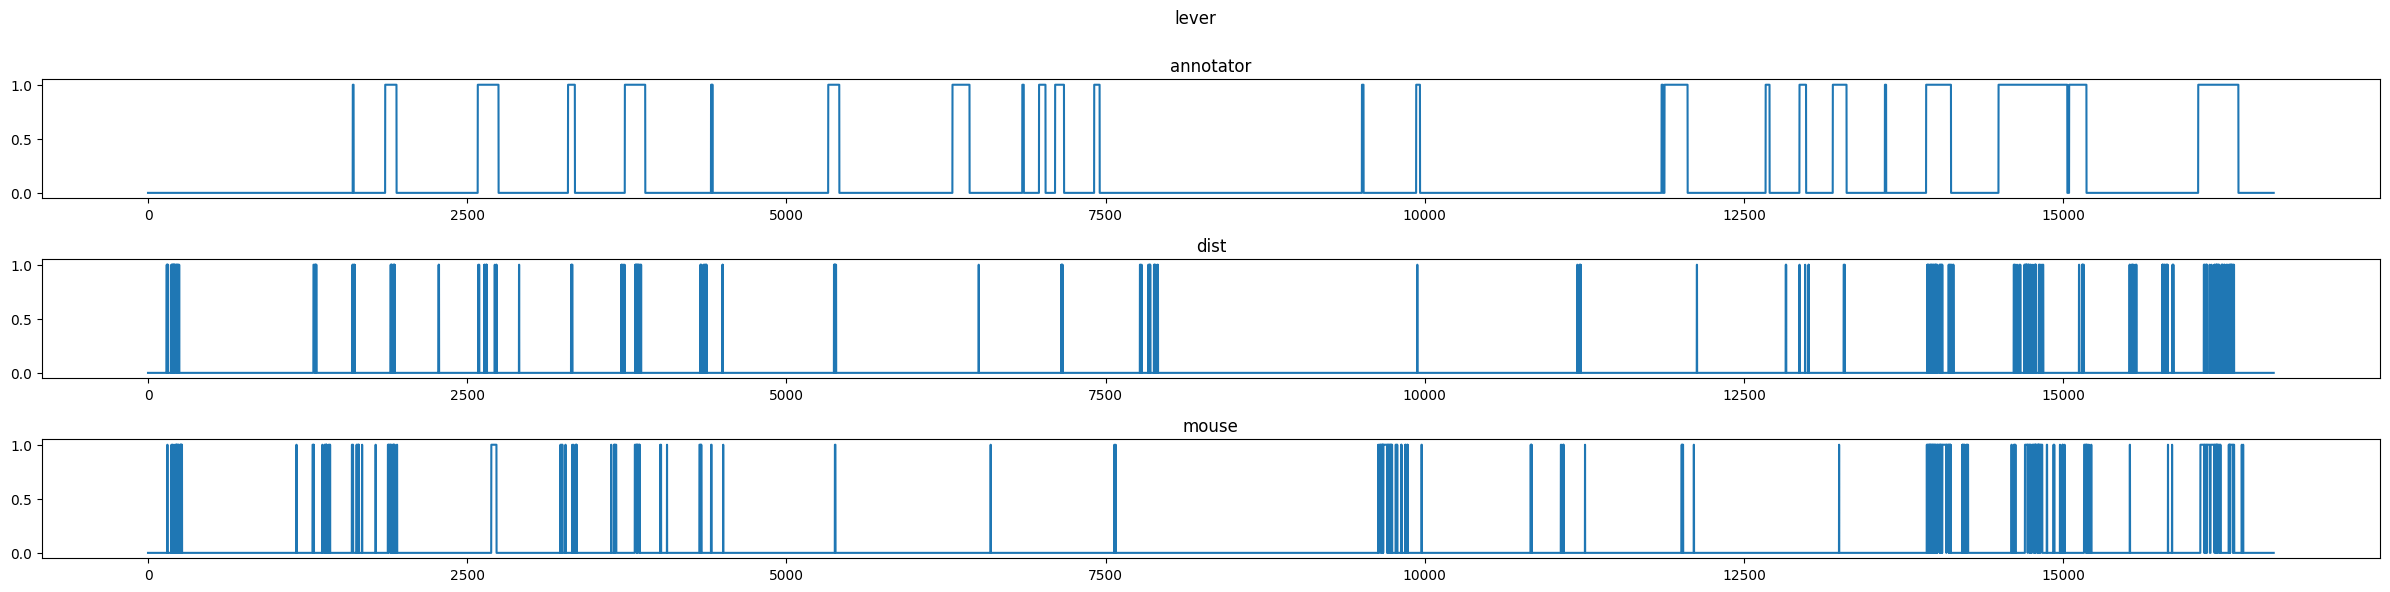

In [29]:
# Assuming annotator_lever_df is already defined and contains 'sum' and 'd' columns.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 6))

ax1.plot(annotator_lever_df['sum'])
ax1.set_title('annotator')

ax2.plot(annotator_lever_df['d_lever'])
ax2.set_title('dist')

ax3.plot(mouse_model_df['lever_bound'])
ax3.set_title('mouse')

fig.suptitle('lever')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

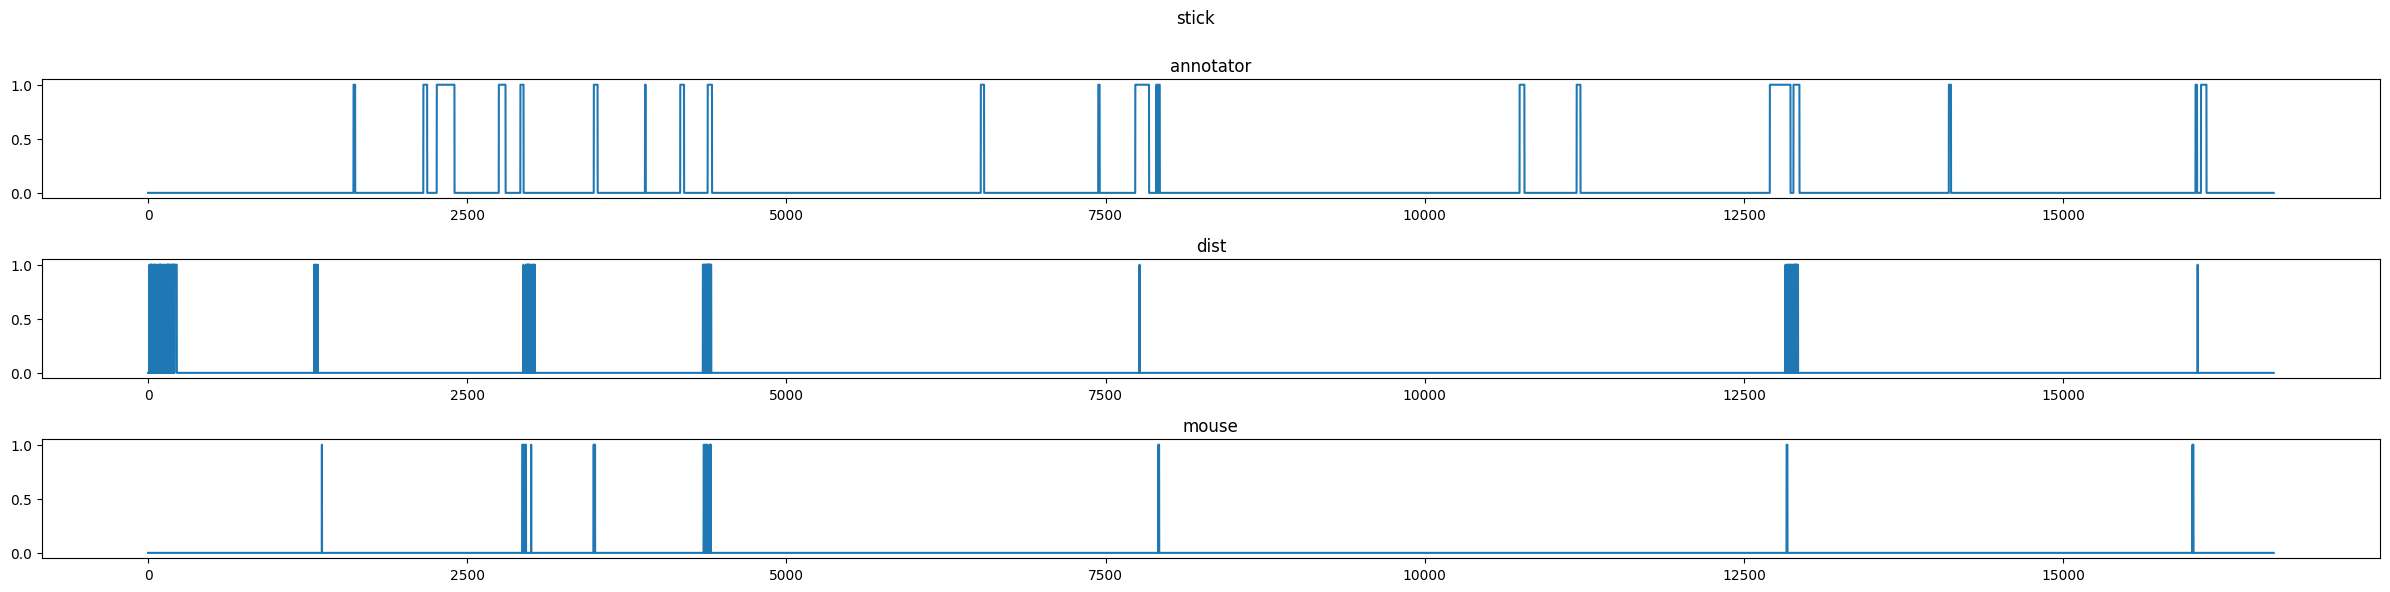

In [30]:
# Assuming annotator_lever_df is already defined and contains 'sum' and 'd' columns.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 6))

ax1.plot(annotator_stick_df['sum'])
ax1.set_title('annotator')

ax2.plot(annotator_stick_df['d_stick'])
ax2.set_title('dist')

ax3.plot(mouse_model_df['stick_bound'])
ax3.set_title('mouse')

fig.suptitle('stick')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

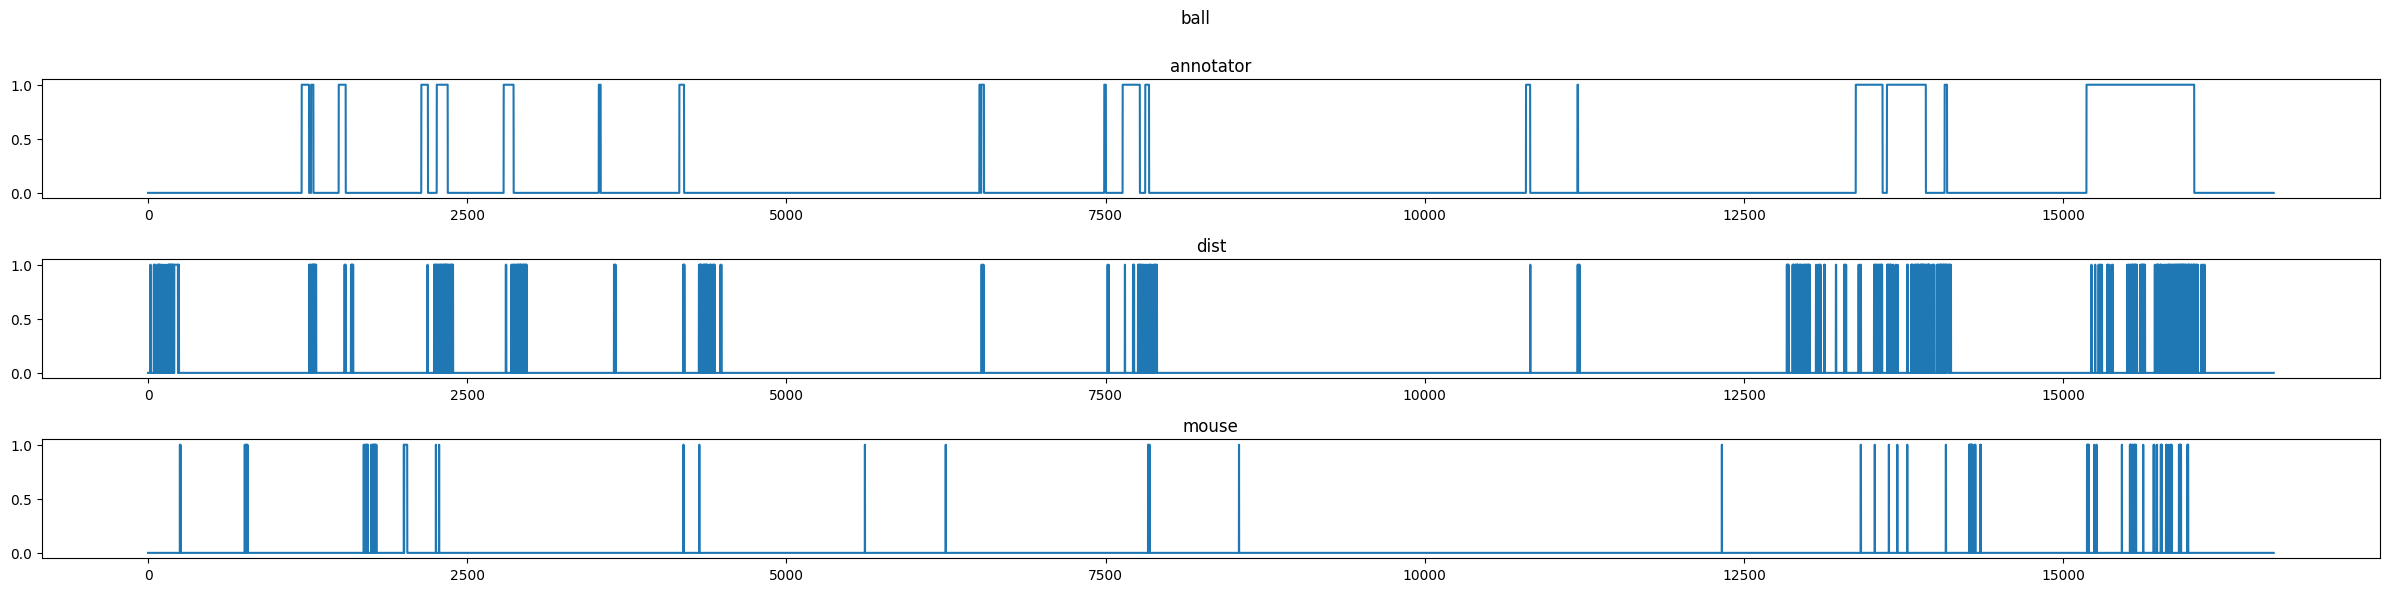

In [48]:
# Assuming annotator_lever_df is already defined and contains 'sum' and 'd' columns.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 6))

ax1.plot(annotator_ball_df['sum'])
ax1.set_title('annotator')

ax2.plot(annotator_ball_df['d_ball'])
ax2.set_title('dist')

ax3.plot(mouse_model_df['ball_bound'])
ax3.set_title('mouse')

fig.suptitle('ball')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

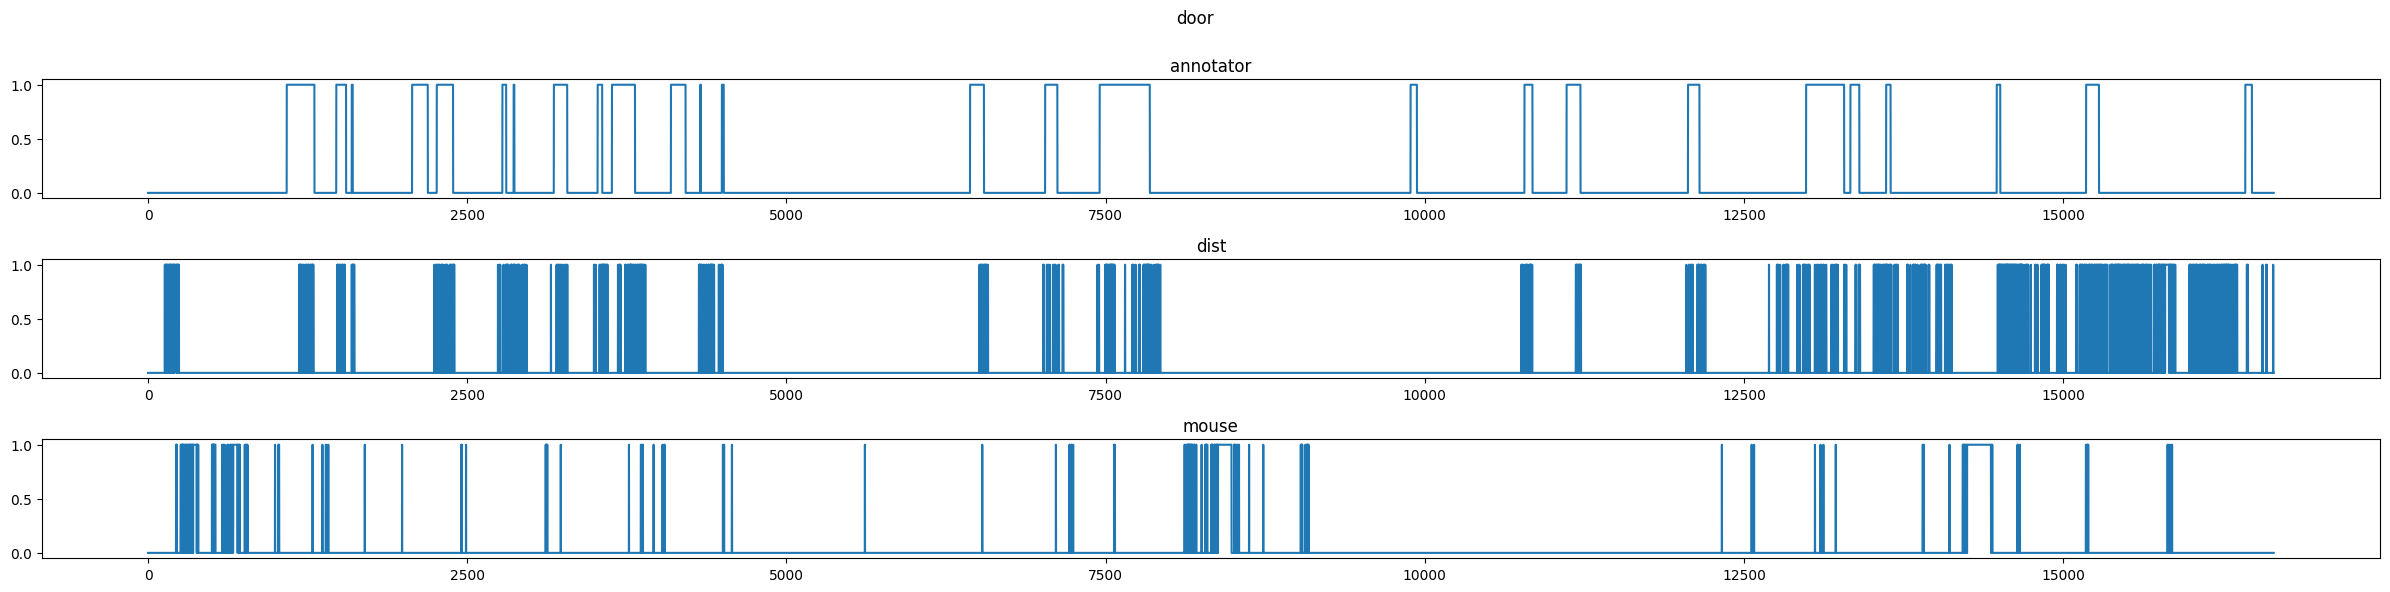

In [73]:
# Assuming annotator_lever_df is already defined and contains 'sum' and 'd' columns.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 6))

ax1.plot(annotator_door_df['sum'])
ax1.set_title('annotator')

ax2.plot(annotator_door_df['d_door'])
ax2.set_title('dist')

ax3.plot(mouse_model_df['door_bound'])
ax3.set_title('mouse')

fig.suptitle('door')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()